In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pandas as pd

In [2]:
config = defaults()
config.batch_size = 1024
config.num_epochs = 200
config.dropout = 0
config.feature_dropout = 0
config.hidden_sizes = [64, 32]
config.units_multiplier = 2
config.num_basis_functions = 64
config.data_path = "heart_failure/train_val_split.csv"
config

namespace(device='cpu',
          seed=2021,
          data_path='heart_failure/train_val_split.csv',
          experiment_name='NAM',
          regression=False,
          num_epochs=200,
          lr=0.0003,
          batch_size=1024,
          logdir='output',
          wandb=True,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0,
          feature_dropout=0,
          decay_rate=0.995,
          l2_regularization=0.5,
          output_regularization=0.5,
          num_basis_functions=64,
          units_multiplier=2,
          shuffle=True,
          cross_val=False,
          num_folds=5,
          num_splits=3,
          fold_num=1,
          num_models=1,
          num_workers=16,
          save_model_frequency=2,
          save_top_k=3,
          use_dnn=False,
          early_stopping_patience=50)

In [3]:
# load training data
from preprocessing import preprocess_hf_for_nam, PREPROCESSED_COLUMN_NAMES
import numpy as np
import pandas as pd
from nam.data import NAMDataset

VAL_SPLIT = 0.2
heart_failure = pd.read_csv("heart_failure/train_val_split.csv")
# heart_failure['target'] = labels
preprocessed, labels = preprocess_hf_for_nam(heart_failure)
x1 = pd.DataFrame(preprocessed, columns=PREPROCESSED_COLUMN_NAMES)
y1 = pd.DataFrame(labels, columns=["HeartDisease"])
frames = [x1, y1]
result = pd.concat(frames, axis=1)

dataset = NAMDataset(config, data_path=result, features_columns=PREPROCESSED_COLUMN_NAMES, targets_column="HeartDisease")
dataset.setup_dataloaders(val_split=VAL_SPLIT, test_split=0)

In [4]:
get_num_units(config, dataset.features)

[64, 64, 64, 4, 64, 64, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [5]:
train_dataloaders = dataset.train_dataloaders()
model = NAM(
  config=config,
  name="NAM",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model

/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/torch/nn/init.py:205: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


NAM(
  (dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (dropout): Dropout(p=0, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=64)
        (1): LinReLU(in_features=64, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (3): FeatureNN(
      (dropout): Dropout(p=0, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (4-5): 2 x FeatureNN(
      (dropout): Dropout(p=0, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=64)
        (1): LinReLU(in_features=64, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): L

In [6]:
import torch
def predict_proba(model, batch):
    with torch.no_grad():
        out = torch.sigmoid(model.forward(batch)[0])
    return out

def predict(model, batch):
    return torch.round(predict_proba(model, batch))

In [7]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
for fold, (trainloader, valloader) in enumerate(train_dataloaders):

    tb_logger = TensorBoardLogger(save_dir=config.logdir,
                                name=f'{model.name}',
                                version=f'fold_{fold + 1}')

    checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                        "/{epoch:02d}-{val_loss:.4f}",
                                        monitor='val_loss',
                                        save_top_k=config.save_top_k,
                                        mode='min')

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(max_epochs=config.num_epochs, logger=tb_logger)
                    #    checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel, trainloader, valloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory output/NAM/fold_1/checkpoints exists and is not empty.

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 68.0 K
-------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to se

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [8]:
from sklearn.metrics import accuracy_score
# print final validation accuracy
for batch in dataset.val_dl:
    predictions = predict(litmodel, batch[0])
    print("Final validation acc:", accuracy_score(batch[1], predict(litmodel, batch[0])))

tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        0., 0.])
torch.Size([146, 20])
0.8767123287671232


In [9]:
from nam.utils.graphing import plot_mean_feature_importance, calc_mean_prediction

# read test dataset and produce the output accuracy
heart_failure_test = pd.read_csv("heart_failure/test_split.csv")
preprocessed, labels = preprocess_hf_for_nam(heart_failure_test)
x1 = pd.DataFrame(preprocessed, columns=PREPROCESSED_COLUMN_NAMES)
y1 = pd.DataFrame(labels, columns=["HeartDisease"])
frames = [x1, y1]
result = pd.concat(frames, axis=1)
dataset = NAMDataset(config, data_path=result, features_columns=PREPROCESSED_COLUMN_NAMES, targets_column="HeartDisease")
dataset.setup_dataloaders(val_split=0, test_split=0.9)
trainer.test(litmodel, dataset.test_dl)


/home/fkmjec/documents/school/eth/2/MLHealth/project-1/nam-venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Accuracy_metric_epoch     0.7818182110786438
     test_loss_epoch        36.334373474121094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 36.334373474121094,
  'Accuracy_metric_epoch': 0.7818182110786438}]

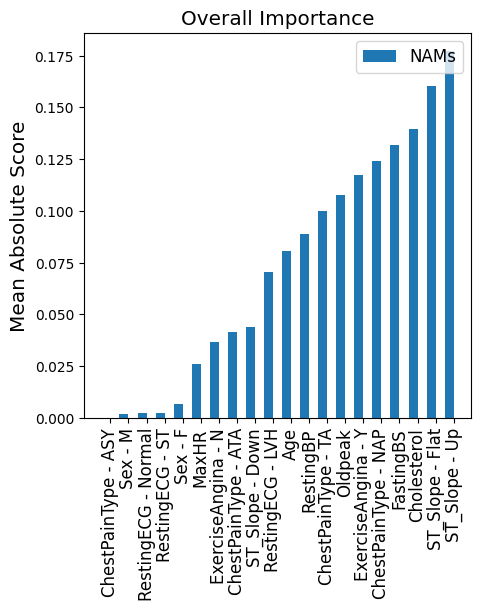

In [10]:
fig = plot_mean_feature_importance(litmodel.model, dataset)